In [87]:
import numpy as np
import pandas as pd
import random
import re
import nltk
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
from nltk.corpus import stopwords
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score
import random
import pprint
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
random.seed(184)

In [88]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Read in data

In [89]:
peek = 20
def present_list_like(name, list_like, peek=peek):
    print(f"{name} peek:")
    print('  ' + '\n  '.join( str(v) for v in list_like[:peek]))

In [90]:
columns = [
    'id', 'label', 'claim', 'subject', 'speaker', 'speaker_job_title', 'state_info',
    'party_affiliation', 'barely_true_counts', 'false_counts',
    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'
]
present_list_like(f"Dataset columns({len(columns)} in total)", columns, len(columns))
def load_data(split):
    df = pd.read_csv(f"./data/{split}.tsv", sep='\t', names=columns)
    df = df.drop(index=[
        idx for idx in df.index if type(df["claim"][idx]) == type(None) or not len(df["claim"][idx])
    ])
    print("The training dataset:")
    df.info()
    print("\nData peek:")
    print(df.head(peek))
    print()
    return df

Dataset columns(14 in total) peek:
  id
  label
  claim
  subject
  speaker
  speaker_job_title
  state_info
  party_affiliation
  barely_true_counts
  false_counts
  half_true_counts
  mostly_true_counts
  pants_on_fire_counts
  context


##Tokenize the data

In [91]:
pad_tkn = "<PAD>"

In [92]:
def tokenize_text(input_text, known_vector_size=None, token_to_idx={}):
    def preprocess_text(text)->str:
        #Letter-level cleaning
        text = text.lower()
        valid_asciis = {9, *range(32, 127)}
        text = ''.join(filter(lambda x: ord(x) in valid_asciis, text))

        #Word/sequence-level cleaning
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'http\S+', '', text)
        stop_words = set(stopwords.words('english'))
        text = ' '.join(word for word in text.split() if word not in stop_words)
        return text

    #Preprocess the text
    for i in range(len(input_text)):
        input_text[i] = preprocess_text(input_text[i])


    #Tokenize
    final_tokens = input_tokens = [nltk.word_tokenize(text) for text in input_text]
    total_tokens = sum(len(tkns) for tkns in final_tokens)

    # Make all token sets the same length
    forced_tkn_set_size = (
        known_vector_size if known_vector_size
        else int(np.percentile([len(tkns) for tkns in final_tokens], 80))
    )
    final_tokens = [
        tkns[:forced_tkn_set_size] + [pad_tkn]*(forced_tkn_set_size - len(tkns))
        for tkns in final_tokens
    ]

    # Present results
    present_list_like(f"Tokenized sentences({len(final_tokens)} sentences, {total_tokens} total tokens)", final_tokens)


    #Index the tokens
    # Map each token to its frequency in the dataset
    if not len(token_to_idx):
        flat_tokens = [word for token_set in final_tokens for word in token_set]
        frequencies = Counter(flat_tokens)
        token_to_idx = {}
        for idx, (word, _) in enumerate(frequencies.most_common()):
            if idx >= 10000:
                break
            token_to_idx[word] = idx + 1
        if pad_tkn not in token_to_idx:
            token_to_idx[pad_tkn] = len(token_to_idx) + 1
    vocab_size = len(token_to_idx)
    print()
    print(vocab_size, "unique tokens")
    present_list_like("Unique tokens", list(token_to_idx.keys()))

    # Index the tokens
    freq_indexed = [
        [(token_to_idx[token] if token in token_to_idx else 0) for token in token_set]
        for token_set in final_tokens
    ]

    # Present results
    present_list_like(f"\nFinal Index Sets(Set_Size = {forced_tkn_set_size}, {len(freq_indexed)} index sets)", freq_indexed)

    return freq_indexed, token_to_idx

In [93]:
def get_freq_indexed_and_labels(split, known_vector_size=None, token_to_idx={}):
    df = load_data(split)
    input_text = df["claim"].to_numpy()
    #Augment input text with the other columns
    other_cols = {
        "context",
        "subject",
        "speaker",
        "speaker_job_title",
        "state_info",
        "party_affiliation",
    }
    for i in range(len(input_text)):
        extra_data = [f"{col}: {df[col].values[i]}" for col in other_cols if df[col].values[i]]
        input_text[i] += " | \n"*(len(extra_data) > 0) + " | \n".join(extra_data)
    input_labels = df["label"].to_numpy()
    code_switch = """"""
    #Fuse some labels
    input_labels = np.array([
        "false" if x in ("false", "half-true", "barely-true", "pants-fire")
        else "true" if x in ("true", "mostly-true")
        else x
        for x in input_labels
    ])
    #"""
    freq_indexed, token_to_idx = tokenize_text(input_text, known_vector_size, token_to_idx)

    return freq_indexed, token_to_idx, input_labels

##Turn the data into tensors

In [94]:
def as_tensors(split, label_encoder=None, known_vector_size=None, token_to_idx={}):
    freq_indexed, token_to_idx, input_labels = get_freq_indexed_and_labels(split, known_vector_size, token_to_idx)
    X = torch.tensor(freq_indexed, dtype=torch.long)
    label_encoder_existed = (type(label_encoder) != type(None))
    label_encoder = (LabelEncoder() if not label_encoder_existed else label_encoder)
    y = (
        label_encoder.fit_transform(input_labels) if not label_encoder_existed
        else label_encoder.transform(input_labels)
    )
    y = torch.tensor(y, dtype=torch.long)
    print(f"{split.upper()} SPLIT:", X.size(0), "overall samples:", X.shape)

    return X, token_to_idx, label_encoder, input_labels, y

##Training

In [95]:
BATCH_SIZE = 32

In [96]:
X_train, token_to_idx, label_encoder, train_input_labels, y_train = as_tensors("train")
label_to_idx = {l: i for i, l in enumerate(label_encoder.classes_)}
train_vocab_size = len(token_to_idx)
input_vector_size = X_train.shape[1]
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

The training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10240 non-null  object 
 1   label                 10240 non-null  object 
 2   claim                 10240 non-null  object 
 3   subject               10238 non-null  object 
 4   speaker               10238 non-null  object 
 5   speaker_job_title     7342 non-null   object 
 6   state_info            8030 non-null   object 
 7   party_affiliation     10238 non-null  object 
 8   barely_true_counts    10238 non-null  float64
 9   false_counts          10238 non-null  float64
 10  half_true_counts      10238 non-null  float64
 11  mostly_true_counts    10238 non-null  float64
 12  pants_on_fire_counts  10238 non-null  float64
 13  context               10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB



In [97]:
train_label_counts = pd.DataFrame({"label": train_input_labels})["label"].value_counts(normalize=True)
print(train_label_counts.shape[0], "labels\n")
print(train_label_counts)

code_switch = "\"""""
#Balance if necessary
print(f"TRAIN SPLIT(pre-balancing):", X_train.size(0), "overall samples:", X_train.shape)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
print()
print(f"TRAIN SPLIT(post-balancing):", X_train.size(0), "overall samples:", X_train.shape)
print(pd.DataFrame({"label": [label_encoder.classes_[y] for y in y_train]})["label"].value_counts())
#"""

2 labels

label
false    0.644727
true     0.355273
Name: proportion, dtype: float64


In [98]:
def train_model(model, dataloader, optimizer, criterion, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_tps = 0
        total_samples = 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() #Track total loss
            #Track total accuracy
            _, predicted_classes = torch.max(predictions, 1)
            epoch_tps += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss/len(dataloader):.4f} | Accuracy: {epoch_tps/total_samples:.4f}")

### The GRU model

In [99]:
#Define the model

import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=token_to_idx[pad_tkn])
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, hidden = self.gru(self.embedding(x))
        return self.fc(hidden[-1])

In [100]:
#Setup to train

# Model and training structure
INPUT_DIM = train_vocab_size + 1
EMBEDDING_DIM = 1000 #Current best: 1000
HIDDEN_DIM = 128
OUTPUT_DIM = train_label_counts.shape[0]
N_LAYERS = 2
DROPOUT = 0.3 #Current best: .3
EPOCHS = 8 #Current best: 8

# Make the model
gru_model = GRUModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
print("Model:", gru_model)

# Move model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_model = gru_model.to(device)

# Optimization & loss setup
optimizer = torch.optim.AdamW(gru_model.parameters(), lr=0.001)
code_switch1 = """"""
class_weights = [1 for _ in range(OUTPUT_DIM)]
class_weights[label_to_idx['true']] = 1
class_weights[label_to_idx['false']] = 2
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
code_switch2 = """
criterion = nn.CrossEntropyLoss() #Current best: no weights
#"""
criterion = criterion.to(device)


Model: GRUModel(
  (embedding): Embedding(10001, 1000, padding_idx=1)
  (gru): GRU(1000, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [101]:
#Train the model
train_model(gru_model, train_loader, optimizer, criterion, device, EPOCHS)

Epoch 1/8 | Loss: 0.5262 | Accuracy: 0.6443
Epoch 2/8 | Loss: 0.4905 | Accuracy: 0.6570
Epoch 3/8 | Loss: 0.4185 | Accuracy: 0.7188
Epoch 4/8 | Loss: 0.2866 | Accuracy: 0.8361
Epoch 5/8 | Loss: 0.1589 | Accuracy: 0.9202
Epoch 6/8 | Loss: 0.0893 | Accuracy: 0.9590
Epoch 7/8 | Loss: 0.0545 | Accuracy: 0.9759
Epoch 8/8 | Loss: 0.0401 | Accuracy: 0.9829


## Save Model Weights

In [102]:
#Save the model weights
torch.save(gru_model.state_dict(), "gru_model_weights.pth")
print("Model weights saved to 'gru_model_weights.pth'")

Model weights saved to 'gru_model_weights.pth'


## Evaluate Model

In [103]:
#Evaluation functions
import typing as tp

# Get predictions
def get_predictions(
    test_loader, model, num_samples,
    pred_type: tp.Literal['model', 'baseline', 'random'] = 'model',
    device=None,
    label_ordering=None, orig_label_counts=None,
    num_classes=None
):
    predictions = []
    y_eval = []

    if pred_type == 'model':
        model.eval()
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                y_eval.extend(batch_y)

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                batch_size = batch_X.size(0)

                outputs = model(batch_X)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu())
        y_eval = torch.tensor(y_eval, dtype=torch.long)
    elif pred_type == 'baseline':
        orig_label_counts = orig_label_counts.sort_index(key=lambda idx: orig_label_counts[idx], inplace=False, ascending=False)
        majority_class = list(label_ordering).index(orig_label_counts.index[0])
        predictions += [majority_class for _ in range(num_samples)]
    else:
        predictions += [random.randint(0, num_classes - 1) for _ in range(num_samples)]

    predictions = torch.tensor(predictions, dtype=torch.long)
    if pred_type == 'model':
        return predictions, y_eval
    return predictions

# Calculate per-class metrics
def per_class_metrics(labels, predictions, num_classes, label_ordering):
    precision_per_class = precision_score(labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0)
    recall_per_class = recall_score(labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0)
    f1_per_class = f1_score(labels, predictions, average=None, labels=np.arange(num_classes), zero_division=0)

    results = []
    for metrics in [precision_per_class, recall_per_class, f1_per_class]:
        results.append({label_ordering[i]: metrics[i] for i in range(len(metrics))})
    return tuple(results)

# Calculate Macro metrics
def macro_metrics(labels, predictions):
    precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)

    return precision_macro, recall_macro, f1_macro

# Calculate Micro metrics
def micro_metrics(labels, predictions):
    precision_micro = precision_score(labels, predictions, average='micro', zero_division=0)
    recall_micro = recall_score(labels, predictions, average='micro', zero_division=0)
    f1_micro = f1_score(labels, predictions, average='micro', zero_division=0)

    return precision_micro, recall_micro, f1_micro

# Get evaluations
def evaluate(labels, num_classes, model_pred, baseline_pred, random_pred, label_ordering):
    results = {}

    for pred_type, predictions in [('Model', model_pred), ('Baseline', baseline_pred), ('Random', random_pred)]:
        curr_results = results[pred_type] = {}

        #Calculate metrics
        accuracy = (predictions == labels).sum().item() / labels.size(0)
        precision_per_class, recall_per_class, f1_per_class = per_class_metrics(labels, predictions, num_classes, label_ordering)
        precision_macro, recall_macro, f1_macro = macro_metrics(labels, predictions)
        precision_micro, recall_micro, f1_micro = micro_metrics(labels, predictions)

        #Save all metrics
        curr_results["Accuracy"] = accuracy
        curr_results["Per-Class Precision"] = precision_per_class
        curr_results["Per-Class Recall"] = recall_per_class
        curr_results["Per-Class F1"] = f1_per_class

        curr_results["Macro Precision"] = precision_macro
        curr_results["Macro Recall"] = recall_macro
        curr_results["Macro F1"] = f1_macro

        curr_results["Micro Precision"]  = precision_micro
        curr_results["Micro Recall"] = recall_micro
        curr_results["Micro F1"] = f1_micro

    return results

In [104]:
def evaluate_data(model, loader, num_classes, num_instances, label_ordering, orig_label_counts, device):
    # Get model, baseline, and random predictions
    #  Use model predictions to get the labels since the
    #   loader might shuffle its values and might not be in the same order as y upon iteration
    model_pred, labels = get_predictions(loader, model, num_instances, pred_type='model', device=device)
    #  Get other prediction types as normal
    baseline_pred = get_predictions(
        loader, model, num_instances, pred_type='baseline',
        label_ordering=label_ordering, orig_label_counts=orig_label_counts
    )
    random_pred = get_predictions(loader, model, num_instances, pred_type='random', num_classes=num_classes)

    print()

    # Print evaluation results
    pprint.pprint(evaluate(labels, num_classes, model_pred, baseline_pred, random_pred, label_ordering))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(labels, model_pred)
    class_labels = label_ordering

    #  Plot the confusion matrix as a heatmap
    def plot_confusion_matrix(conf_matrix, class_labels):
        sns.heatmap(
            conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.tight_layout()
        plt.show()
    print("\n")
    plot_confusion_matrix(conf_matrix, class_labels)


###Val Set Results

In [105]:
X_val, _, _, _, y_val = as_tensors("valid", label_encoder, input_vector_size, token_to_idx)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

The training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    1284 non-null   object
 1   label                 1284 non-null   object
 2   claim                 1284 non-null   object
 3   subject               1284 non-null   object
 4   speaker               1284 non-null   object
 5   speaker_job_title     939 non-null    object
 6   state_info            1005 non-null   object
 7   party_affiliation     1284 non-null   object
 8   barely_true_counts    1284 non-null   int64 
 9   false_counts          1284 non-null   int64 
 10  half_true_counts      1284 non-null   int64 
 11  mostly_true_counts    1284 non-null   int64 
 12  pants_on_fire_counts  1284 non-null   int64 
 13  context               1272 non-null   object
dtypes: int64(5), object(9)
memory usage: 140.6+ KB

Data peek:
       


{'Baseline': {'Accuracy': 0.6728971962616822,
              'Macro F1': 0.4022346368715084,
              'Macro Precision': 0.3364485981308411,
              'Macro Recall': 0.5,
              'Micro F1': 0.6728971962616822,
              'Micro Precision': 0.6728971962616822,
              'Micro Recall': 0.6728971962616822,
              'Per-Class F1': {'false': 0.8044692737430168, 'true': 0.0},
              'Per-Class Precision': {'false': 0.6728971962616822, 'true': 0.0},
              'Per-Class Recall': {'false': 1.0, 'true': 0.0}},
 'Model': {'Accuracy': 0.631619937694704,
           'Macro F1': 0.5749043707719282,
           'Macro Precision': 0.5764107018268285,
           'Macro Recall': 0.573941798941799,
           'Micro F1': 0.631619937694704,
           'Micro Precision': 0.631619937694704,
           'Micro Recall': 0.631619937694704,
           'Per-Class F1': {'false': 0.7301768397033657,
                            'true': 0.4196319018404908},
           'Per-Cla

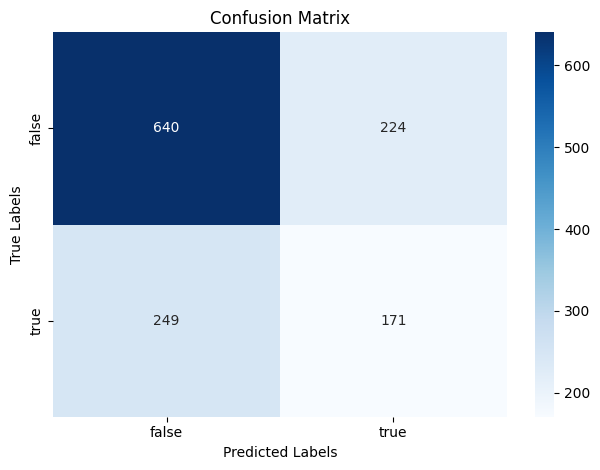

In [106]:
evaluate_data(gru_model, val_loader, OUTPUT_DIM, y_val.size(0), label_encoder.classes_, train_label_counts, device)

###Test Set Results

In [107]:
X_test, _, _, _, y_test = as_tensors("test", label_encoder, input_vector_size, token_to_idx)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

The training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    1267 non-null   object
 1   label                 1267 non-null   object
 2   claim                 1267 non-null   object
 3   subject               1267 non-null   object
 4   speaker               1267 non-null   object
 5   speaker_job_title     942 non-null    object
 6   state_info            1005 non-null   object
 7   party_affiliation     1267 non-null   object
 8   barely_true_counts    1267 non-null   int64 
 9   false_counts          1267 non-null   int64 
 10  half_true_counts      1267 non-null   int64 
 11  mostly_true_counts    1267 non-null   int64 
 12  pants_on_fire_counts  1267 non-null   int64 
 13  context               1250 non-null   object
dtypes: int64(5), object(9)
memory usage: 138.7+ KB

Data peek:
       


{'Baseline': {'Accuracy': 0.6456195737963694,
              'Macro F1': 0.39232613908872904,
              'Macro Precision': 0.3228097868981847,
              'Macro Recall': 0.5,
              'Micro F1': 0.6456195737963694,
              'Micro Precision': 0.6456195737963694,
              'Micro Recall': 0.6456195737963694,
              'Per-Class F1': {'false': 0.7846522781774581, 'true': 0.0},
              'Per-Class Precision': {'false': 0.6456195737963694, 'true': 0.0},
              'Per-Class Recall': {'false': 1.0, 'true': 0.0}},
 'Model': {'Accuracy': 0.6077348066298343,
           'Macro F1': 0.5598249642623718,
           'Macro Precision': 0.562560553633218,
           'Macro Recall': 0.5590717759106082,
           'Micro F1': 0.6077348066298343,
           'Micro Precision': 0.6077348066298343,
           'Micro Recall': 0.6077348066298343,
           'Per-Class F1': {'false': 0.7050445103857567,
                            'true': 0.41460541813898705},
           'P

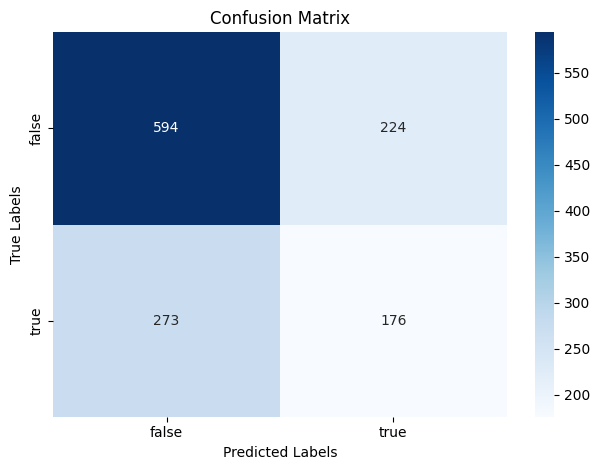

In [108]:
evaluate_data(gru_model, test_loader, OUTPUT_DIM, y_test.size(0), label_encoder.classes_, train_label_counts, device)